# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv 

Что хранится в столбцах:
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info"> Спасибо большое!! Полезно, а то как раз думала, как можно побольше сделать</div>

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

datasets = [df0, df1, df2]

for dataset in range(len(datasets)):
    print(f'ДАТАСЕТ {dataset}')
    display(datasets[dataset].info())

ДАТАСЕТ 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

ДАТАСЕТ 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

ДАТАСЕТ 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [3]:
for dataset in range(len(datasets)):
    display(f'Количество явных дубликатов в {dataset}: {datasets[dataset].duplicated().sum()}')

'Количество явных дубликатов в 0: 0'

'Количество явных дубликатов в 1: 0'

'Количество явных дубликатов в 2: 0'

In [4]:
for dataset in range(len(datasets)):
    print(f'ДАТАСЕТ {dataset}')
    display(datasets[dataset].describe())

ДАТАСЕТ 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


ДАТАСЕТ 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


ДАТАСЕТ 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В данных нет пропусков и явных дубликатов, но зато есть столбик id, который ни на что не влияет. Его удалим.

In [5]:
for dataset in datasets:
    dataset = dataset.drop('id', axis=1, inplace=True)

Построим графики для каждого датасета, чтобы взглянуть на данные поближе.

In [6]:
def grafics(df):    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1) 
    plt.title('Ящик с усами')
    
    plt.ylabel('Объём')
    plt.boxplot (x=df['product'])
    plt.subplot(1, 2, 2)
    plt.title('Гистограмма распределения объёма')
    plt.xlabel('Объём')
    plt.ylabel('Количество')
    plt.hist(x = df['product'], bins=35, range = (0, 200))
    plt.show()

График для датасета №0


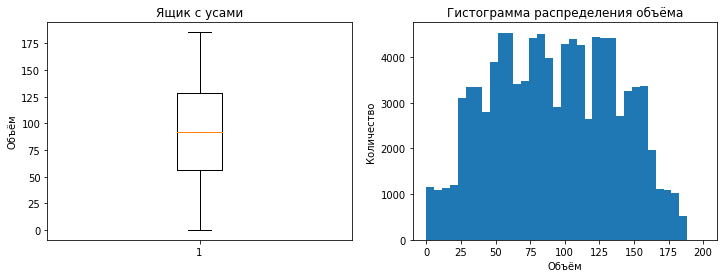

График для датасета №1


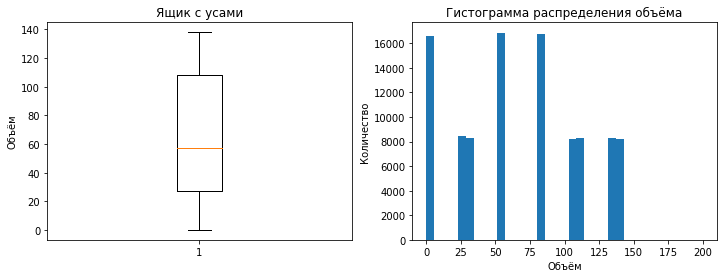

График для датасета №2


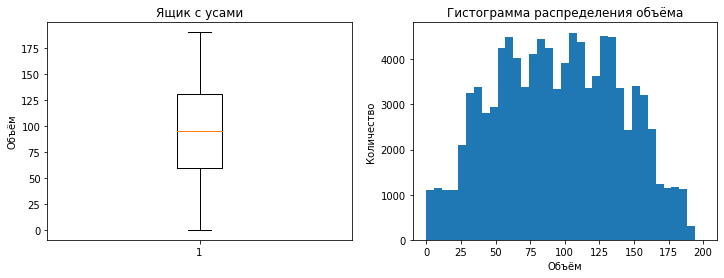

In [7]:
for dataset in range(len(datasets)):
    print(f'График для датасета №{dataset}')
    grafics(datasets[dataset])

Если сравнивать графики трех датасетов, то видно, что с датасетом №1 что-то не так: много пропусков. Стоит посмотреть на нули и процент от всего количества данных в датасете.

In [8]:
def zero(data):
    zero = data[data['product'] == 0]['product'].count()
    percent = zero / data.shape[0]
    print(f'Количество нулевых значений: {zero}')
    print(f'Процент нулевых значений: {percent}')

In [9]:
for dataset in range(len(datasets)):
    print(f'Датасет №{dataset}')
    zero(datasets[dataset])
    print()

Датасет №0
Количество нулевых значений: 1
Процент нулевых значений: 1e-05

Датасет №1
Количество нулевых значений: 8235
Процент нулевых значений: 0.08235

Датасет №2
Количество нулевых значений: 1
Процент нулевых значений: 1e-05



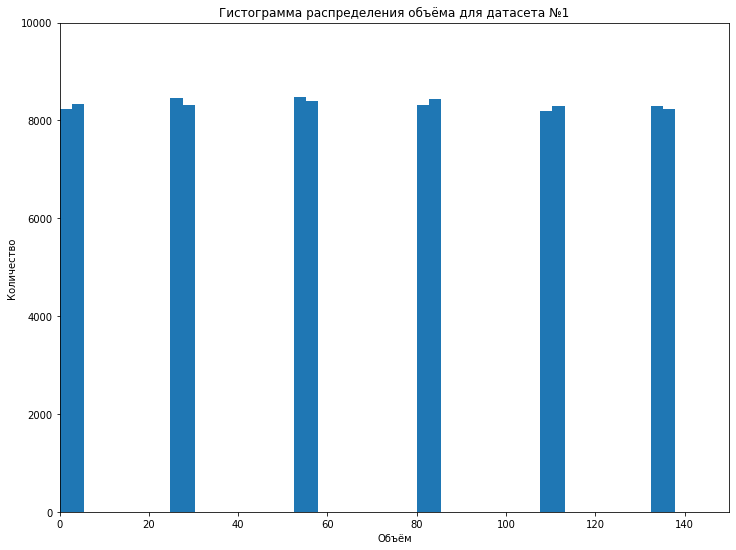

In [10]:
plt.figure(figsize=[12,9])
plt.title('Гистограмма распределения объёма для датасета №1')
plt.xlabel('Объём')
plt.ylabel('Количество')
plt.hist(x=df1['product'], bins=50)
plt.xlim([0, 150])
plt.ylim([0, 10000])
plt.show()

В датасете №1 видно, что есть 8,2% нулевых значений. Если сравнивать с другими датасетами (№0 и №2), то можно предположить, что данные утеряны или их реально нет. 

Можно сказать, что всю нефть выкачали? :) Не знаю. А вот по ЗБЧ: 10000 данных распределены с +-одинаковым шагом, нет нормального распределения. 

Посмотрим на корреляцию между признаками.

In [11]:
def cor(data):
    plt.figure(figsize=(8,8), dpi= 80)
    sns.heatmap(data.corr(), cmap='summer', center=0, annot=True)

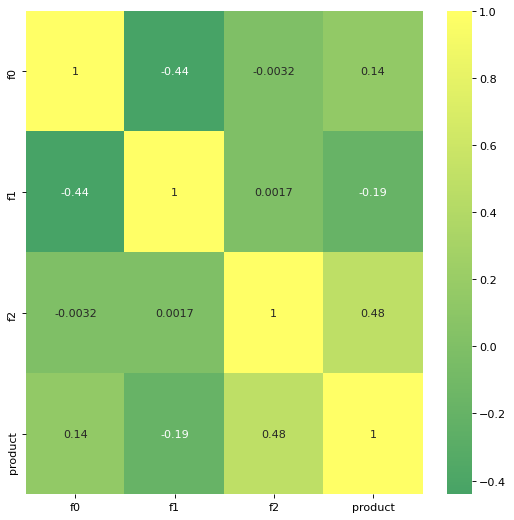

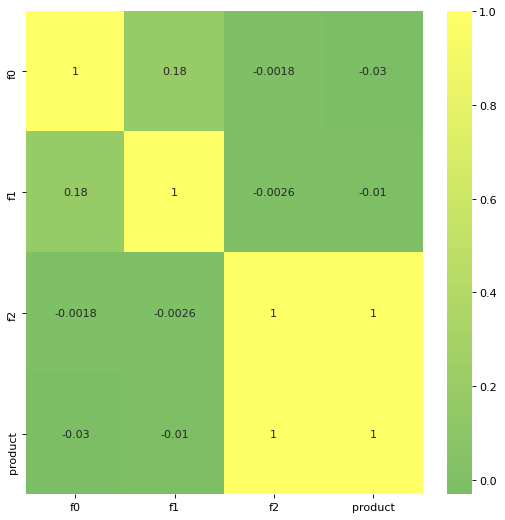

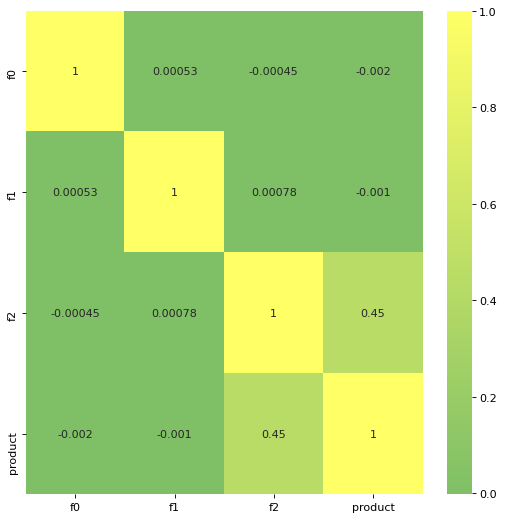

In [12]:
for dataset in range(len(datasets)):
    cor(datasets[dataset])
    print()

В датасете №1 есть высокая линейная зависимость между признаком в колонке 'f2' и целевым признаком product. В датасетах №0 и №2 зависимость так же есть, но меньше (0.42 и 0.45)

**Вывод:**

1. Удален столбец id из всех датасетов. Он ни на что не влияет.
2. Явных дубликотов и пропусков в данных нет.
3. В датасете №0 и №2 всего по 1 нулевому значению. В датасете №1 пропущенных значений - 8235 (8,2% от 10 тысяч)
4. Целевой признак products. Признаки: f0, f1 и f2. (Нам не сказали, за что они отвечают, но они важные).

Данные хорошего качества, дальнейшей обработки не требуют, поэтому приступим к обучению модели.

## Обучение и проверка модели

Разделим наши датасеты на выборки.

In [13]:
def train_check(data):
    #деление на целевой признак и признаки
    features = data.drop("product", axis=1)
    target = data["product"]
    #деление на обучающую и валидационную выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    #масштабирование
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    #обучение модели
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    
    #вычисление метрик
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Средний запас: {0:.2f}".format(average_product))
    print()
    
    return (predictions, target_valid.reset_index(drop=True), rmse, average_product)

In [14]:
print('Датасет №0')
predictions_0, target_0, rmse_0, avg_0 = train_check(df0)
print('Датасет №1')
predictions_1, target_1, rmse_1, avg_1 = train_check(df1)
print('Датасет №2')
predictions_2, target_2, rmse_2, avg_2 = train_check(df2)

Датасет №0
RMSE: 37.58
Средний запас: 92.59

Датасет №1
RMSE: 0.89
Средний запас: 68.73

Датасет №2
RMSE: 40.03
Средний запас: 94.97



У региона №0 и №2 высокий запас нефти, метрика RMSE выше. У региона №1 метрика RMSE ниже (а значит модель лучше соответствует набору данных). Это возможно связано с высокой корреляцией между признаком f2 и целевым признаком product. Однако у региона №1 маленький запас нефти и, как выяснилось на этапе предобработки, утеряны/пропущены данные.

**Вывод:**

Написали функцию, в которой:
1. Выделили целевой признак и признаки для обучения: product - целевой.
2. Разделили датасеты на обучающую и валидационную выборки.
3. Применили масштабирование к признакам.
4. Обучили модель линейной регрессии.
5. Вычислили метрики RMSE (среднеквадратическое отклонение) и средний запас нефти по каждому региону.

Метрики дали такие результаты:
1. RMSE у региона №0 и №2 выше (и примерно одинаковы), но запас нефти больше (так же примерно одинаков). 
2. RMSE у региона №1 ниже, но запас нефти ниже из-за нулевых значений в данных. Возможно данные были утеряны и восстановлены некорректно.

Необходимо рассчитать прибыль для каждого региона, но выбирать будем скорее между регионами №0 и №2, т.к. №1 имеет мало запасов.

## Подготовка к расчёту прибыли

In [15]:
number_bores = 500 
bores_needed = 200
budget = 10_000_000_000 
barrel_price = 450_000 
risk = 2.5

In [16]:
profit_per_point = budget / bores_needed
print(f'Средняя прибыль на лучшую точку: {profit_per_point} тыс.руб.')

barrels_per_point = profit_per_point / barrel_price
print(f'Средний объем нефти на точку: {barrels_per_point} тыс. баррелей')

barrels = budget / barrel_price
print(f'Средний объем нефти на регион: {barrels} тыс. баррелей')

Средняя прибыль на лучшую точку: 50000000.0 тыс.руб.
Средний объем нефти на точку: 111.11111111111111 тыс. баррелей
Средний объем нефти на регион: 22222.222222222223 тыс. баррелей


Посчитаем фактические запасы.

In [17]:
print('Средний запас фактичекой нефти на скважину в регионе №0', round(df0['product'].mean(), 3))
print('Средний запас фактичекой нефти на скважину в регионе №1', round(df1['product'].mean(), 3))
print('Средний запас фактичекой нефти на скважину в регионе №2', round(df2['product'].mean(), 3))

Средний запас фактичекой нефти на скважину в регионе №0 92.5
Средний запас фактичекой нефти на скважину в регионе №1 68.825
Средний запас фактичекой нефти на скважину в регионе №2 95.0


**Вывод:**

Посчитаны средние значения:
1. Средняя прибыль на лучшую точку: 50000000.0 тыс.руб.
2. Средний объем нефти на точку: 111.111 тыс. баррелей
3. Средний объем нефти на регион: 22222.222 тыс. баррелей

Получается, что средний объем нефти на точку должен составлять 111.111 тыс. баррелей, в то время как фактический средний запас на точку в 3-х регионах ниже: 92.5, 68.825 и 95.0.
Получается, что каждый их регионов убыточный. Рассчитаем прибыль и риски.

## Расчёт прибыли и рисков 

Применим технику Bootstrap для 1000 выборок, чтобы найти распределение прибыли. Убыток - отрицательные значения. Нужно найти: среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [18]:
predictions_0 = pd.Series(predictions_0)
predictions_1 = pd.Series(predictions_1)
predictions_2 = pd.Series(predictions_2)

In [19]:
# функция для нахождения прибыли
def income(target, bores, count, budget):
    bores_sorted = bores.sort_values(ascending=False) # сортировка по предсказанию
    selected = target[bores_sorted.index][:count] # лучшие скваэены по фактическим индексам
    income = barrel_price * selected.sum() # прибыль с выбранных скважин
    profit = income - budget # считаем прибыль
    return profit

In [20]:
def bootstrap(target, predictions):
    values = []

    # Bootstrap
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=number_bores, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        value = income(target_subsample, pred_subsample, bores_needed, budget)
        values.append(value)

    # убытки
    values = pd.Series(values)
    risk = (values < 0).mean()

    # 95%-й доверительный интервал 
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    print('Средняя прибыль:', round(values.mean() / 1000000, 2), 'млн. руб')
    print(f'95% доверительный интервал: ({round(lower, 3)}, {round(upper, 3)})')
    print('Риск убытков: {:.1%}'.format((values < 0).mean()))

    # сравниваем результат с крайним значением рисков
    if (risk * 100) <= 2.5:
          print('Риск убытков меньше 2.5%')
    else:
          print('Риск убытков больше 2.5%')    

In [21]:
print('Регион №0')
bootstrap(target_0, predictions_0)

Регион №0
Средняя прибыль: 425.94 млн. руб
95% доверительный интервал: (-102090094.838, 947976353.358)
Риск убытков: 6.0%
Риск убытков больше 2.5%


In [22]:
print('Регион №1')
bootstrap(target_1, predictions_1)

Регион №1
Средняя прибыль: 515.22 млн. руб
95% доверительный интервал: (68873225.371, 931547591.257)
Риск убытков: 1.0%
Риск убытков меньше 2.5%


In [23]:
print('Регион №2')
bootstrap(target_2, predictions_2)

Регион №2
Средняя прибыль: 435.01 млн. руб
95% доверительный интервал: (-128880547.33, 969706954.18)
Риск убытков: 6.4%
Риск убытков больше 2.5%


**Вывод:**

1. Создали фунцию для нахождения прибыли и функцию для бутстрапа.
2. Посчитали среднюю прибыль, 95% доверительный интервал и риск убытков для каждого датасета (региона).

*Регион №0*
- Средняя прибыль: 425.94 млн. руб
- 95% доверительный интервал: (-102090094.838, 947976353.358)
- Риск убытков: 6.0%

*Регион №2*
- Средняя прибыль: 435.01 млн. руб
- 95% доверительный интервал: (-128880547.33, 969706954.18)
- Риск убытков: 6.4%


*Регион №2*
- Средняя прибыль: 435.01 млн. руб
- 95% доверительный интервал: (-128880547.33, 969706954.18)
- Риск убытков: 6.4%

Получилось, что регион №1 хоть и имеет меньшие запасы сырья, но тем не менее средняя прибыль выше, а риск убытков составляет 1% (что меньше нашей границы в 2.5%)

## Вывод

Задача состояла в **выборе локации для скважины**.

Данные геологоразведки трёх регионов находились в 3-х файлах.
Что хранилось в столбцах:
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).

Данные хорошего качества. Сильной обработки не потребовалось. Что потребовалось сделать с данными:
1. Удален столбец id из всех датасетов. Он ни на что не влияет.
2. Явных дубликотов и пропусков в данных нет.
3. В датасете №0 и №2 всего по 1 нулевому значению. В датасете №1 пропущенных значений - 8235 (8,2% от 10 тысяч)
4. Целевой признак products. Признаки: f0, f1 и f2. (Нам не сказали, за что они отвечают, но они важные).

Обучили модель линейной регрессии. Посчитали RMSE (среднеквадратическое отклонение) и средний запас нефти для каждого датасета.

1. У региона №0 и №2 высокий запас нефти, метрика RMSE выше. 
2. У региона №1 метрика RMSE ниже (а значит модель лучше соответствует набору данных). Это возможно связано с высокой корреляцией между признаком f2 и целевым признаком product. Однако у региона №1 маленький запас нефти и, как выяснилось на этапе предобработки, утеряны/пропущены данные.

Посчитаны средние значения на этапе подготовки к расчету прибыли:
1. Средняя прибыль на лучшую точку: 50000000.0 тыс.руб.
2. Средний объем нефти на точку: 111.111 тыс. баррелей
3. Средний объем нефти на регион: 22222.222 тыс. баррелей

Получается, что средний объем нефти на точку должен составлять 111.111 тыс. баррелей, в то время как фактический средний запас на точку в 3-х регионах ниже: 92.5, 68.825 и 95.0.
Получалось, что каждый их регионов убыточный, НО мы посчиьали расчет прибыли и рисков для каждого датасета. 

Риск убытков у датасета №1 оказался ниже границы в 2.5% и равнялся 1%. В то время как рис убытков у регионов с большим количеством нефти (но высоким RMSE) соответственно 6 и 6.4%


Получается, что мы убираем регионы №0 и №2, так как риски относительно велики (6% и 6.4%). Остается **регион №1 (geo_data_1.csv)**, чей риск ниже установленной границы (1%). Доверительный интервал показывает, что даже при не очень удачном выборе места разработка скважин окупится.